#Modelo de markowitz

In [ ]:
import pandas as pd #pandas es una libreria que permite trabajar con datos
import datetime #libreria para manejo de fechas
import numpy as np #libreria para operaciones con matrices, polinomios, entre otros
import cvxpy as cv #libreria de optimizacion convexa
import seaborn as sns
from dateutil.relativedelta import relativedelta #funcion para poder realizar operaciones con fechas
from datetime import datetime
from datetime import timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
!pip install yfinance
import yfinance as yf

In [ ]:
#Sumar dos días a la fecha actual
now = datetime.now()
new_date = now + timedelta(days=2)
print(new_date)

2022-12-09 02:58:39.528674


In [ ]:
# tickers = ["BTC-USD","XRP-USD","SOL-USD","DOGE-USD"]
# start = "2022-1-1"
# # end = "2022-12-31"

tickers = ["TSLA","WMT","GOOG","AMZN"]
start = "2019-1-1"
end = "2019-12-31"
data = yf.download(tickers, start = start, end = end)
data = data["Adj Close"]
data = data.dropna()

[*********************100%***********************]  4 of 4 completed


In [ ]:
log_returns = np.log(data/data.shift(1))

In [ ]:
#Vector de pesos
w = (0.25, 0.25, 0.25, 0.25)
x = (log_returns*w).sum(axis = 1)
x

Date
2019-01-02    0.000000
2019-01-03   -0.022899
2019-01-04    0.040890
2019-01-07    0.024061
2019-01-08    0.007989
                ...   
2019-12-23    0.006400
2019-12-24    0.003067
2019-12-26    0.017334
2019-12-27   -0.001610
2019-12-30   -0.015688
Length: 251, dtype: float64

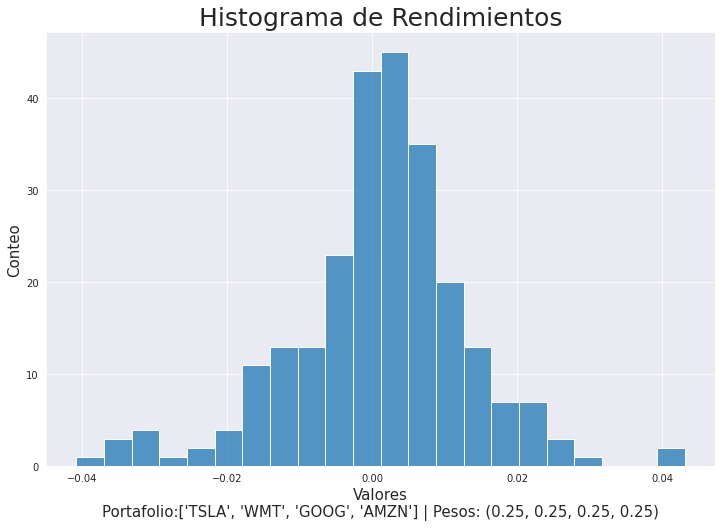

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,8))
ax = sns.histplot(x)
ax.set_title("Histograma de Rendimientos",fontsize = '25')
ax.set_xlabel("Valores\nPortafolio:{0} | Pesos: {1}".format(tickers,w),fontsize = 15)
ax.set_ylabel("Conteo",fontsize = 15)
plt.show()

In [ ]:
x.describe()

count    251.000000
mean       0.000980
std        0.012300
min       -0.040743
25%       -0.004538
50%        0.001599
75%        0.007737
max        0.043148
dtype: float64

#Matriz de covarianza

In [ ]:
(log_returns*w).cov()*252

,AMZN,GOOG,TSLA,WMT
AMZN,0.003271,0.002119,0.002065,0.000696
GOOG,0.002119,0.003638,0.001833,0.000529
TSLA,0.002065,0.001833,0.015102,0.000247
WMT,0.000696,0.000529,0.000247,0.001288


In [ ]:
(log_returns*w).corr()

,AMZN,GOOG,TSLA,WMT
AMZN,1.000000,0.614331,0.293825,0.338887
GOOG,0.614331,1.000000,0.247281,0.244543
TSLA,0.293825,0.247281,1.000000,0.056031
WMT,0.338887,0.244543,0.056031,1.000000


In [ ]:
(log_returns*w).mean()

AMZN    0.000182
GOOG    0.000245
TSLA    0.000291
WMT     0.000266
dtype: float64

In [ ]:
log_returns.cov()*252

,AMZN,GOOG,TSLA,WMT
AMZN,0.052332,0.033907,0.033040,0.011130
GOOG,0.033907,0.058210,0.029327,0.008471
TSLA,0.033040,0.029327,0.241627,0.003954
WMT,0.011130,0.008471,0.003954,0.020612


In [ ]:
log_returns.corr()

,AMZN,GOOG,TSLA,WMT
AMZN,1.000000,0.614331,0.293825,0.338887
GOOG,0.614331,1.000000,0.247281,0.244543
TSLA,0.293825,0.247281,1.000000,0.056031
WMT,0.338887,0.244543,0.056031,1.000000


In [ ]:
log_returns.mean()

AMZN    0.000729
GOOG    0.000980
TSLA    0.001162
WMT     0.001065
dtype: float64

# Construcción de la barrera eficiente de Markowitz

Para la obtención de la barrera eficiente obtendremos los diferentes niveles posibles de returns para el portafolio y obtendremos el portafolio de Markowitz, en este caso el que minimiza la varianza dado un nivel de rendimientos esperado, de esta manera, este portafolio minimiza la varianza dado un nivel de rendimientos admisible, y esto se hará para todos los posibles niveles de rendimientos, a continuación graficaremos y obtendremos la barrera eficiente.

Note que estamos utilizando el enfoque de minimización de volatilidad dado un nivel de rendimientos esperado para la obtención de los diferentes portafolios de Markowitz, dicho enfoque puede ser encontrado en las diapositivas enviadas al inicio del curso:

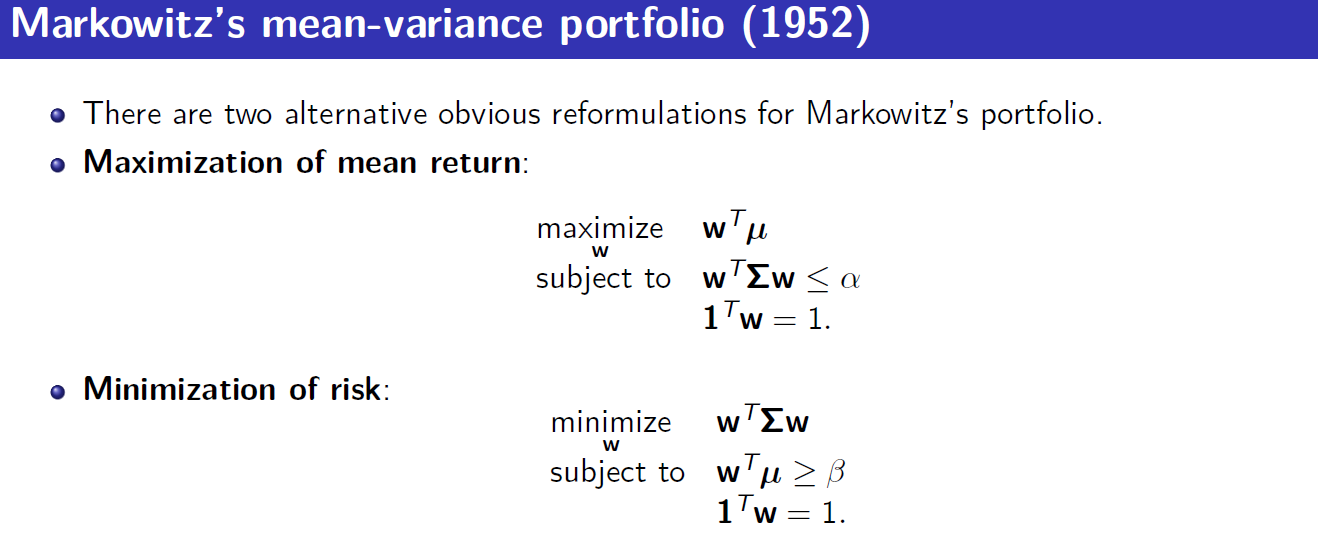

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return

In [ ]:
medias = log_returns.mean()*252 # Rendimientos
cov = log_returns.cov()*252 # Matriz de covarianzas
cov = cov.values

In [ ]:
size= len(tickers) # Cantidad de elementos en el portafolio

In [ ]:
# Función a minimizar
def compute_portfolio_variance(x, covariance_matrix):
    variance = np.dot(x.T, np.dot(covariance_matrix, x)).item()
    return variance

In [ ]:
def Markowitz(size, cov, medias, target):
    # initialise optimisation
    x = np.zeros([size,1])
    # initialise constraints
    cons = [{"type": "eq", "fun": lambda x: np.transpose(medias).dot(x).item() - target},\
            {"type": "eq", "fun": lambda x: sum(abs(x)) - 1}]
    bnds = [(0, None) for i in range(size)]
    # compute optimisation
    res = minimize(compute_portfolio_variance, x, args=(cov), constraints=cons, bounds=bnds)
    weights =  res.x
    return weights

In [ ]:
Markowitz(size, cov, medias, -1.15909081) # Ejemplo

array([5.67835222e-14, 2.18325235e-15, 0.00000000e+00, 0.00000000e+00])

In [ ]:
# Para obtener el rango posible de rendimientos
minret = min(medias)
maxret = max(medias)

In [ ]:
# Discretización del intervalo de posibles rendimientos
returns = minret + np.linspace(0.1,0.9,1000) * (maxret-minret)

In [ ]:
volatilities = np.zeros([len(returns),1])

In [ ]:
counter = 0
for target in returns:
    w = Markowitz(size, cov, medias, target)
    volatilities[counter] = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    counter += 1

In [ ]:
volatilities = [i[0] for i in volatilities]

In [ ]:
frontera = pd.DataFrame({"Volatilidad":volatilities,"Return":returns})

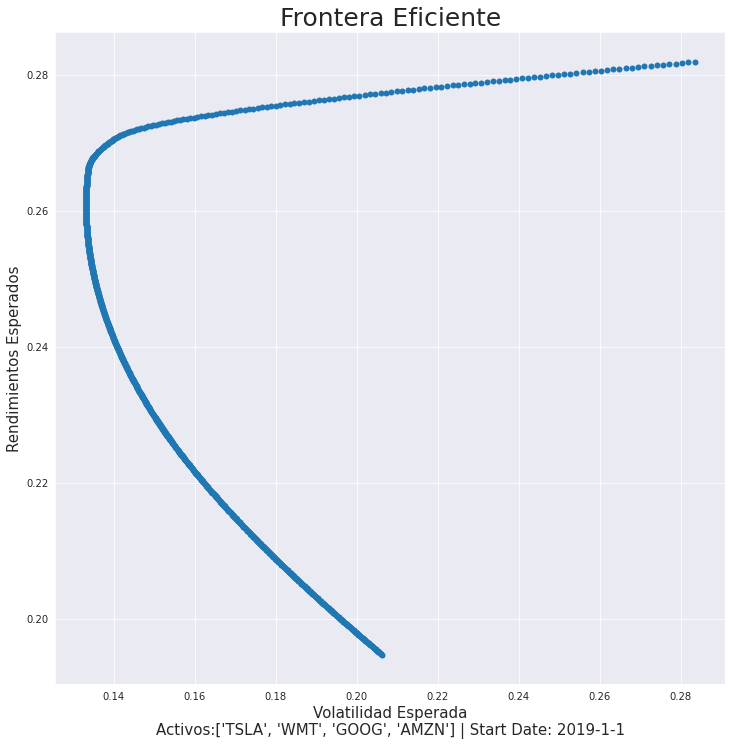

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,12))
ax = sns.scatterplot(x = volatilities,y = returns,linewidth=0)
ax.set_title("Frontera Eficiente", fontsize = 25)
ax.set_xlabel("Volatilidad Esperada\nActivos:{0} | Start Date: {1}".format(tickers,start),fontsize = 15)
ax.set_ylabel("Rendimientos Esperados",fontsize = "15")
plt.show()

Además, mostrermos el conjunto de portafolios admisible:

In [ ]:
n = 2500

port_returns = []
port_vol = []
port_w = []
for _ in range(n):
    w = np.random.random(len(tickers))
    w /= np.sum(w)
    port_w.append(w)
    port_returns.append(np.sum(w * log_returns.mean()) * 252)
    port_vol.append(np.sqrt(np.dot(w.T, np.dot(log_returns.cov() * 252, w))))

port_returns = np.array(port_returns)
port_vol = np.array(port_vol)

In [ ]:
portafolios = pd.DataFrame({"Pesos":port_w,'Return': port_returns, 'Volatilidad':port_vol})

In [ ]:
rf = 0.0
portafolios["Sharpe"] = (portafolios["Return"] - rf)/portafolios["Volatilidad"]
max_port = portafolios[portafolios.Sharpe == max(portafolios.Sharpe)]
max_port = max_port.reset_index(drop=True)

In [ ]:
max_sharpe = round(max_port["Sharpe"].values[0],3)
max_port_w = max_port["Pesos"].values[0]

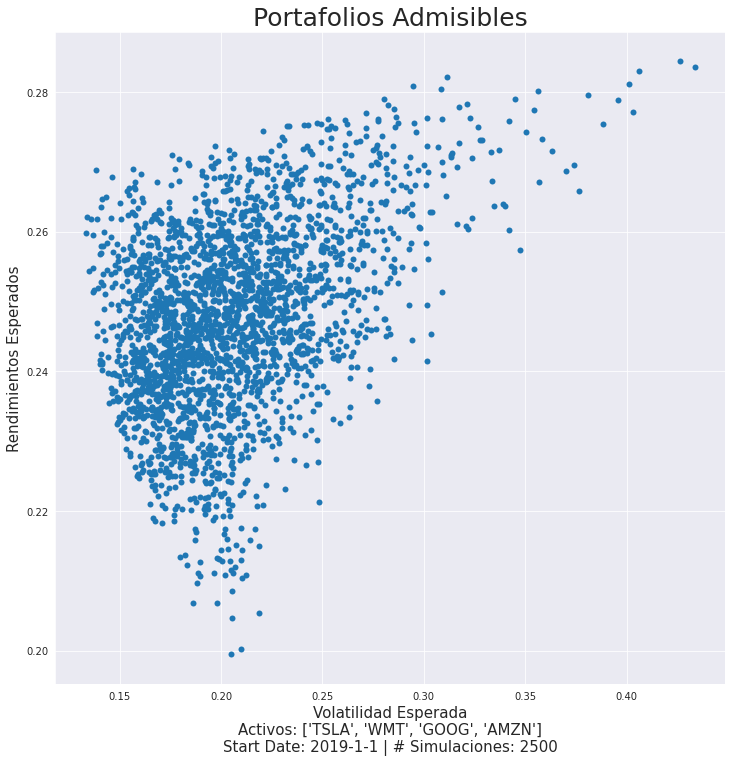

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,12))
ax = sns.scatterplot(x = "Volatilidad",y = "Return",data = portafolios, linewidth=0)
ax.set_title("Portafolios Admisibles",fontsize = '25')
ax.set_ylabel("Rendimientos Esperados",fontsize = "15")
ax.set_xlabel("Volatilidad Esperada\n"+"Activos: "+str(tickers)+\
              "\nStart Date: "+start+" | # Simulaciones: "+str(n),fontsize = "15")
plt.show()

In [ ]:
print("El cociente de Sharpe para el portafolio {0} más grande está dado por:{1}\nAdemás,\
 note que los pesos de dicho portafolio son: {2}".format(tickers, max_sharpe,max_port_w))

El cociente de Sharpe para el portafolio ['TSLA', 'WMT', 'GOOG', 'AMZN'] más grande está dado por:1.958
Además, note que los pesos de dicho portafolio son: [0.06410141 0.08377771 0.03524102 0.81687987]


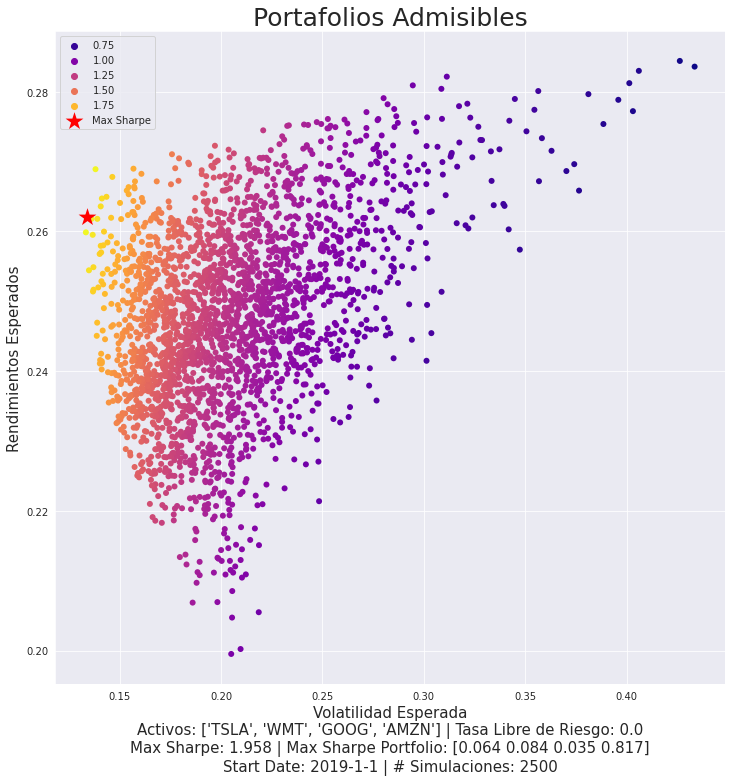

In [ ]:
# viridis, plasma
sns.set_style("darkgrid")
plt.figure(figsize = (12,12))
ax = sns.scatterplot(x = "Volatilidad",y = "Return",data = portafolios, hue = "Sharpe",\
                     palette='plasma',linewidth=0)
sns.scatterplot(x = "Volatilidad",y = "Return", data = max_port, color = "red",\
                label = "Max Sharpe",s = 350, marker="*",linewidth=0)
ax.set_title("Portafolios Admisibles",fontsize = '25')
ax.set_ylabel("Rendimientos Esperados",fontsize = "15")
ax.set_xlabel("Volatilidad Esperada\n"+"Activos: "+str(tickers)+\
              " | Tasa Libre de Riesgo: "+str(rf)+"\nMax Sharpe: "+str(max_sharpe)+\
              " | Max Sharpe Portfolio: "+str(np.round(list(max_port["Pesos"]),3)[0])+\
              "\nStart Date: "+start+" | # Simulaciones: "+str(n),fontsize = "15")
plt.show()

# Modelo de Black Litterman

Luego vamos a calcular el portafolio de Black Litterman usando los retornos historicos como input.

<style>
    h1 {
    text-align: center;
    color: Black
    }
    h2, h3, h4, p {
    text-align: left;
    color: Black
    }
    table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
    text-align: center;
    padding: 0px
    }
    div.output {
    align-items: left
    }
</style>

Black Litterman

Partes del NB
1. Modelo de Black Litterman.
   1. Modelo de Equilibrio General.
   2. Modelo de referencia de Black Litterman.
   3. Creación de Views.
   4. Modelo de estimación mixta de Theil y Goldberg
   5. Modelo de Black Litterman
2. Aplicación Práctica del Modelo.
   1. Usando el modelo de equilibrio general.
   2. Usando valores historicos.
   3. Ejemplo del uso del modelo de Black Litterman.

## 1. Modelo de Black Litterman
El modelo de Black Litterman es un modelo que permite a los administradores de portafolios incorporar sus views o perspectivas acerca del rendimiento futuro de los activos y combinarlos con la información historica, de esta forma se pueden generar portafolios que incorporen nueva información adicional y ademas permite crear portafolios mas diversificados en comparación con el enfoque puro de Markowitz en la primera parte..

### A. Modelo de Equilibrio General.
El modelo de equilibrio general empieza con la funcion de utilidad de los inversionistas.
<br>
<br>$$ U = w * \Pi -\lambda w^T\Sigma w$$
<br>$$ \pi = \mu - r_f$$
<br>
Donde:
<br>$U:$ es la función de Utilidad del inversionista.
<br>$w:$ es el vector de pesos de cada activo en el portafolio.
<br>$\Pi:$ es el vector de retorno en exceso promedio de cada activo del portafolio.
<br>$\mu:$ es el vector de retorno promedio de cada activo del portafolio.
<br>$r_f:$ es la tasa libre de riesgo.
<br>$\lambda:$ es un factor de aversión al riesgo.
<br>$\Sigma:$ es la matriz de covarianzas de los retornos.

Para hallar el valor óptimo para el inversionista, hallamos el valor maximo de la utilidad respecto a los pesos de cada activo, para ellos calculamos la derivada de $U$ respecto a $x$ y la igualamos a cero:
<br>
<br>$$ U' = \Pi -\lambda \Sigma w = 0$$
<br>$$\Pi = \lambda \Sigma w$$
### B. Modelo de referencia de Black Litterman.
Asumiendo que la media de los retornos de los activos $\mu \sim N(\pi, \Sigma)$, lo cual tambien se puede expresar de la siguiente forma:
<br>
<br>$$I \mu = \Pi + \epsilon $$
<br>$$\Phi = \tau\Sigma $$
<br>
Donde:
<br>$I:$ es la matriz identidad.
<br>$\mu:$ es el vector de retornos en exceso promedio estimado de los activos.
<br>$\Pi:$ es el vector de retornos en exceso promedio de equilibrio de los activos.
<br>$\epsilon:$ es el error de la estimación del modelo.
<br>$\Phi:$ es el matriz de covarianzas de $\epsilon$.
### C. Creación de Views.
Las views o perspectivas pueden crearse a partir de la estimación de los retornos promedio iniciales y añadiendoles pesos y valores objetivo esperados:
<br>
<br>$$P \mu = Q + \nu $$
<br>$$\Omega = diag(P(\tau\Sigma)P')$$
<br>
Donde:
<br>$P:$ es la matriz de pesos o matriz de views que representan la relacion entre el retorno de cada activo.
<br>$Q:$ es el vector de retornos del view.
<br>$\nu:$ es el error de la estimación de las views.
<br>$\Omega:$ es el matriz de covarianzas de $\nu$.
<br>

Para ilustrar como se diseñan las views vamos a asumir un vector de retornos $x = [0.3, 0.2, 0.1]$ y vamos a decir que el primer activo va a tener un rendimiento superior al tercero en $0.05$ y el segundo activo va a tener un rendimiento absoluto de $0.10$. Expresando esos rendimientos en las formas de las matrices $P$ y $Q$:
<br>
<br>$$P = \begin{bmatrix}1 & 0 & -1\\ 0 & 1 & 0\end{bmatrix}$$
<br>$$Q = \begin{bmatrix}0.05 \\ 0.10\end{bmatrix}$$

### D. Modelo de estimación mixta de Theil y Goldberg.
Es un modelo de nos permite incorporar nueva información dentro de una regresión ya calculada, para ello se realiza lo siguiente:
<br>
<br>$$ Y = X\beta + \epsilon $$
<br>
Donde:
<br>$Y:$ es el vector de la variable dependiente.
<br>$X:$ es el vector de la variable independiente.
<br>$\beta:$ es el coeficiente de la regresión.
<br>$\epsilon:$ es el vector de errores.

Luego tenemos nueva información la sobre el coeficiente $\beta$:
<br>
<br>$$ Q = P\beta + \nu $$
<br>
Donde:
<br>$Q:$ es el vector de nueva información de la variable dependiente.
<br>$P:$ es el vector de nueva información de la variable independiente.
<br>$\beta:$ es el coeficiente de la regresión.
<br>$\nu:$ es el vector de errores.

Luego fusionamos ambas ecuaciones y se tiene:

<br>$$\begin{bmatrix}Y \\ Q\\ \end{bmatrix} = \begin{bmatrix}X \\ P\\ \end{bmatrix}\beta + \begin{bmatrix}\epsilon \\ \nu \\ \end{bmatrix}$$
<br>
Si aplicamos minimos cuadrados para obtener $\beta$ se obtiene lo siguiente:
<br>$$\beta = \left[\begin{bmatrix}X' & P'\\ \end{bmatrix} \begin{bmatrix}\Phi & 0 \\ 0 &\Omega \\ \end{bmatrix}^{-1} \begin{bmatrix}X \\ P\\ \end{bmatrix}\right]^{-1}  \begin{bmatrix}X' & P'\\ \end{bmatrix} \begin{bmatrix}\Phi & 0 \\ 0 &\Omega \\ \end{bmatrix}^{-1} \begin{bmatrix}Y \\ Q \\ \end{bmatrix}$$
<br>
Finalmente se obtiene:
<br>$$\beta = \left[ X' \Phi^{-1} X + P \Omega^{-1}P \right]^{-1}\left[ X' \Phi^{-1} Y + P \Omega^{-1}Q \right]$$
<br>
Donde:
<br>$\Phi:$ es el matriz de covarianzas de $\epsilon$.
<br>$\Omega:$ es el matriz de covarianzas de $\nu$.

### D. Modelo de Black Litterman.
El modelo de black litterman parte de combinar los 4 modelos anteriores, se utiliza el modelo de referencia y el de creación de views y se combinan en el modelo de Theil and Goldberg, como en el modelo de referencia la matriz $X$ es la matriz identidad $I$ se obtiene la siguiente ecuación:
<br>
<br>$$\Pi_{bl} = \left[(\tau\Sigma)^{-1}+ P \Omega^{-1}P \right]^{-1}\left[(\tau\Sigma)^{-1} \Pi + P \Omega^{-1}Q \right]$$
<br>
Esta ecuación tiene una formula equivalente que permite reducir el uso de matrices inversas:
<br>
<br>$$\Pi_{bl} = \Pi + \tau \Sigma P'\left[(P \tau\Sigma P') + \Omega \right]^{-1}\left[Q - P\Pi\right]$$
<br>
Al incorporar views tambien se modifica la matriz de covarianzas de los retornos, la nueva matriz de covarianzas se obtiene con las siguientes ecuaciones:
<br>
<br>$$M = \left((\tau\Sigma)^{-1} + P'\Omega^{-1} P \right)^{-1}$$
<br>$$\Sigma_{bl} = \Sigma + M$$
<br>
Con esta ecuacion y la ecuación de equilibrio inicial se pueden obtener los pesos de equilibrio de Black Litterman, considerando que no existe ninguna restricción en los pesos, mediante un proceso de optimización inversa:
<br>
<br>$$w_{bl} = (\lambda \Sigma_{bl})^{-1} \Pi_{bl}$$
<br>
## 2. Aplicación Práctica del Modelo.
En la practica, normalmente no se utilizan los pesos del modelo de Black Litterman $w_{bl}$, sino que se toman los retornos esperados de los activos de Black Litterman $\Pi_{bl}$ y la matriz de covarianza de Black Litterman $\Sigma_{bl}$ y se utilizan como inputs del modelo de markowitz.
### A. Usando el modelo de equilibrio general.
En la practica los retornos iniciales $\Pi$ pueden calcular basado en el modelo de equilibrio general considerando unos pesos iniciales $w_{0}$:
<br>
<br>$$\Pi = \lambda\Sigma w_{0}$$
### B. Usando valores historicos.
Otra forma de calcular los retornos iniciales $\Pi$ es usando los retornos promedios de los activos $\mu$ y restandoles la tasa libre de riesgo $r_f$:
<br>
<br>$$\Pi = \mu - r_{f}$$
Donde:
<br>$\mu:$ es el vector de retornos promedio de los activos.
### C. Ejemplo del uso del modelo de Black Litterman.
Primero utilizaremos el modelo de markowitz para hallar la frontera eficiente y el portafolio que maximiza el ratio de sharpe.

In [ ]:
#Sumar dos días a la fecha actual
now = datetime.now()
new_date = now + timedelta(days=2)
print(new_date)

2022-12-09 02:58:50.756308


In [ ]:
####################################################################
# Importando la data
####################################################################

tickers = ["WMT", "GOOG",	"^GSPC",	"PEP",	"TSLA", "MSFT", "AMZN", "GCARSOA1.MX",	"GE"]
end = datetime.now()
start = end - timedelta(days = 1260) #juntar 1260 días (generalmente se mueve 2 arriba y 2 abajo)
data = yf.download(tickers, start = start, end = end)
data = data["Adj Close"]
precios = data.dropna()
returns=precios.pct_change().dropna()

[*********************100%***********************]  9 of 9 completed


In [ ]:


#mostrando los activos cargados
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(returns)


,AMZN,GCARSOA1.MX,GE,GOOG,MSFT,PEP,TSLA,WMT,^GSPC
Date,,,,,,,,,
2019-06-27,0.003399,-0.024237,0.012658,-0.003510,0.001643,-0.004761,0.016281,-0.000544,0.003823
2019-06-28,-0.005593,-0.001396,0.010587,0.004554,-0.001416,-0.004252,0.002782,0.003542,0.005757
2019-07-01,0.015082,-0.011738,0.012381,0.015764,0.012840,0.005643,0.016603,0.001177,0.007672
2019-07-02,0.006305,0.029836,-0.000941,0.012114,0.006633,0.004247,-0.011533,0.008859,0.002928
2019-07-03,0.002425,0.001236,-0.000941,0.009296,0.006443,0.011780,0.046092,0.006452,0.007672
...,...,...,...,...,...,...,...,...,...
2022-11-30,0.044579,0.018162,0.003619,0.062971,0.061624,0.015992,0.076702,-0.003595,0.030948
2022-12-01,-0.010773,0.032584,-0.008259,-0.001676,-0.001764,0.008353,0.000000,0.006233,-0.000868
2022-12-02,-0.014346,-0.009904,0.019001,-0.004443,0.001296,-0.001130,0.000822,-0.000978,-0.001195


In [ ]:
####################################################################
# Definiendo las funciones para graficar
####################################################################

#Se necesita esta linea para que se puedan ver los graficos en el jupyter notebook
# py.init_notebook_mode()

def grafico_frontera(frontera, titulo, riesgo, sharpe = None, bl = None):
    riesgo='Riesgo - ' + str(riesgo)
    trace1 = go.Scatter(
        x=frontera['port_risk'],
        y=frontera['port_ret'],
        name='Frontera',
        mode='markers',
        marker=dict(
    #        size='16',
            color = frontera['port_sharpe'].values,
            colorscale='Rainbow',
#            reversescale=True,
            showscale=True
        )
    )

    if sharpe is None:
        data = [trace1]
    else:
        trace2 = go.Scatter(
            x = sharpe[1],
            y = sharpe[0],
            name = 'Sharpe Ratio',
            mode = 'markers',
            marker = dict(
                        size= 16,
                        color = 'rgb(0, 190, 0)'
                        )
        )
        data = [trace1, trace2]

    if bl is not None:
        trace3 = go.Scatter(
            x = bl[1],
            y = bl[0],
            name = 'Black Litterman',
            mode = 'markers',
            marker = dict(
                        size= 16,
                        color = 'rgb(17, 157, 255)'
                        )
        )
        data.append(trace3)

    layout= go.Layout(
        title= titulo,
        autosize=False,
        width=700,
        height=500,
        xaxis= dict(
            title= riesgo,
            exponentformat='none',
            tickformat="0.4f"
        ),
        yaxis=dict(
            title= 'Retorno',
            exponentformat='none',
            tickformat="0.4f"
        ),
        showlegend= False
    )

    fig=go.Figure(data=data, layout=layout)
    py.iplot(fig, show_link=False)

def grafico_frontera_2(frontera, titulo, riesgo, sharpe = None, bl = None):
    plt.figure(figsize=(12, 6))
    plt.scatter(frontera.port_risk,frontera.port_ret,c=frontera.port_sharpe,cmap='rainbow')
    plt.title(str(titulo))
    plt.xlabel('Riesgo - '+ str(riesgo))
    plt.ylabel('Returns')
    plt.colorbar()
    if sharpe != None:
        plt.scatter(sharpe[1], sharpe[0], color='g', s = 200)
    if bl != None:
        plt.scatter(bl[1], bl[0], color=(17/255, 157/255, 255/255), s = 200)

Ahora vamos a desarrollar una funcion que nos calcule la frontera eficiente de Markowitz:

In [ ]:
####################################################################
# Definiendo la función de frontera effciente media varianza
####################################################################

def frontera_MVO(returns):
    mu=np.matrix(np.mean(returns,axis=0))
    sigma=np.cov(returns.T)

    w = cv.Variable((mu.shape[1],1))
    g = cv.Parameter(nonneg=True)

    ret=mu*w
    risk=cv.quad_form(w,sigma)

    port_ret=[]
    port_risk=[]
    port_sharpe=[]
    portafolio={'port_ret':port_ret,
                'port_risk':port_risk,
                'port_sharpe':port_sharpe}

    gs=np.arange(0,10,0.1)
    for i in gs:
        g.value=i
        prob = cv.Problem(cv.Maximize(ret-g*risk),
                           [cv.sum(w) == 1,
                            w >=0.01])
        prob.solve()
        weights=np.matrix(w.value)
        try:
            port_ret.append(np.asscalar(mu*weights)*252)
            port_risk.append(np.asscalar(np.sqrt(weights.T*sigma*weights*252)))
            port_sharpe.append(np.asscalar(mu*weights)/np.asscalar(np.sqrt(weights.T*sigma*weights)))
        except:
            continue
    return pd.DataFrame(portafolio)

Y ya con la función por fin podremos obtener la frontera eficiente

/usr/local/lib/python3.8/dist-packages/cvxpy/expressions/expression.py:593: UserWarning:


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.


<ipython-input-211-3276de52ab9a>:31: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

<ipython-input-211-3276de52ab9a>:32: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

<ipython-input-211-3276de52ab9a>:33: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



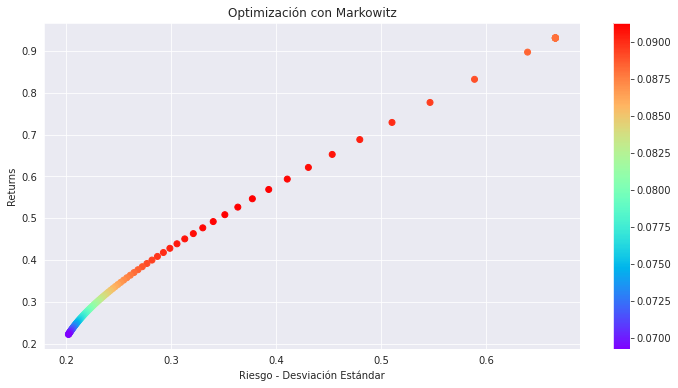

In [ ]:
frontera_1=frontera_MVO(returns.values)
grafico_frontera(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar')
grafico_frontera_2(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar')

Ahora continuando con el ejemplo formularemos el problema del máximo ratio de sharpe, lo resolveremos y graficaremos con python =)

/usr/local/lib/python3.8/dist-packages/cvxpy/expressions/expression.py:593: UserWarning:


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 13 times so far.


<ipython-input-213-51ca3b5d3a23>:30: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

<ipython-input-213-51ca3b5d3a23>:31: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



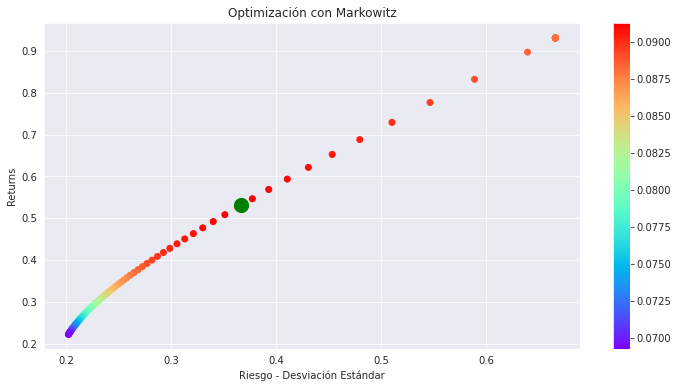

In [ ]:
####################################################################
# Modelo Sharpe Ratio Media Varianza
####################################################################

#definiendo los inputs
mu = np.matrix(np.mean(returns,axis=0))
sigma = np.cov(returns.T)

def Sharpe_Portafolio(mu, sigma, riskfree = 0):
    w = cv.Variable((mu.shape[1],1))
    k = cv.Variable((1,1))
    rf = cv.Parameter(nonneg=True)
    rf.value = 0
    u = np.ones((1,mu.shape[1]))*rf

    #definiendo el problema, funcion objetivo y reestricciones
    prob = cv.Problem(cv.Minimize(cv.quad_form(w,sigma)),
                   [(mu-u)*w == 1,
                   k >= 0,
                   w >= 0.01*k, #para que el peso minimo sea 0.01%
                   cv.sum(w) == k])
    #resolviendo el problema
    prob.solve(solver=cv.ECOS)
    w_MV = np.matrix(w.value/k.value)
    return w_MV

w_MV = Sharpe_Portafolio(mu, sigma)
#almacenando la data
SR_MV=[]
SR_MV.append([np.asscalar(mu*w_MV*252)])
SR_MV.append([np.asscalar(np.sqrt(w_MV.T*sigma*w_MV*252))])

#graficando la frontera con el ratio de sharpe
grafico_frontera(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar', SR_MV)
grafico_frontera_2(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar', SR_MV)

Ahora vamos a crear una función que nos calcule los resultados del modelo de Black Litterman, es decir que calcule  $\Pi_{bl}$ y $\Sigma_{bl}$:

In [ ]:
####################################################################
# Definiendo la función para calcular los retornos de Black Litterman
####################################################################

def black_litterman(mu, sigma, w_0, P, Q, tau, delta, riskfree = 0, historical = False):
    w = np.matrix(w_0)
    P = np.matrix(P)
    Q = np.matrix(Q)
    S = np.matrix(sigma)
    Omega = np.matrix(np.diag(np.diag(P * (tau * S) * P.T)))

    if historical == False:
        PI = delta * S * w.T
    elif historical == True:
        PI = mu.T - riskfree

    M = ((tau * S).I + P.T * Omega.I * P).I
    PI_1 = ((tau * S).I + P.T * Omega.I * P).I * ((tau * S).I * PI + P.T * Omega.I * Q)
#    PI_1 = PI + (tau * S* P.T) * (P * tau * S * P.T + Omega).I * (Q - P * PI)
#    M = tau * S - (tau * S * P.T) * (P * tau * S * P.T + Omega).I * P * tau * S
    S_1 = S + M
    w_1 = (1/(1 + tau)) * (delta * S_1).I * PI_1
    mu = PI_1 + riskfree

    return mu.T, S_1


Ahora vamos a crear 3 views, como trabajamos con data diaria vamos a establercer las siguientes views:
* AAPL va a rendir menos que GE en 0.05%
* XOM va a rendir 0.05%
* S&P500 va a rendir menos que PEP en 0.02%

In [ ]:
delta = 3 #delta, lambda o factor de aversion al riesgo
tau = 1/returns.shape[0]

P = np.array([[0, -1, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1],
              [-1, 0, 0, 0, 0, 1, 0, 0, 0]])
Q = np.array([[0.0005], [0.0005], [0.0002]])

print('Matriz de Views')
display(P)
print('Matriz de Retornos de Views')
display(Q)


Matriz de Views


array([[ 0, -1,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1],
       [-1,  0,  0,  0,  0,  1,  0,  0,  0]])

Matriz de Retornos de Views


array([[0.0005],
       [0.0005],
       [0.0002]])

Siguiendo con el ejemplo vamos a calcular el portafolio de Black Litterman usando el modelo de equilibrio general como input.

/usr/local/lib/python3.8/dist-packages/cvxpy/expressions/expression.py:593: UserWarning:


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

<ipython-input-216-0135fbe74816>:12: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

<ipython-input-216-0135fbe74816>:13: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



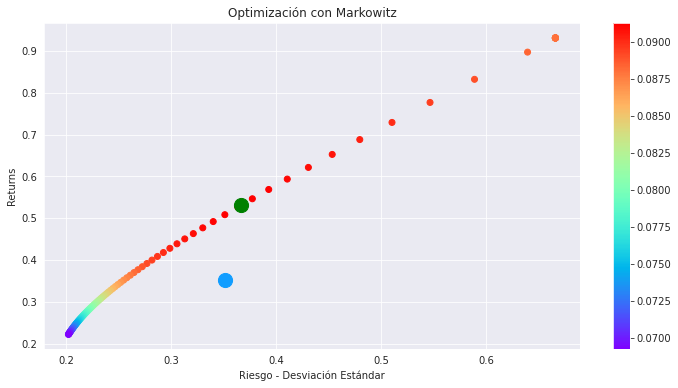

In [ ]:
####################################################################
# Calculando los pesos del modelo de Black Litterman
# usando los pesos de equilibrio general
####################################################################

PI_bl, sigma_bl = black_litterman(mu, sigma, w_MV.T, P, Q, tau, delta, riskfree = 0, historical = False)

w_BL_1 = Sharpe_Portafolio(np.matrix(PI_bl), sigma_bl, riskfree = 0)

#almacenando la data
SR_BL_1=[]
SR_BL_1.append([np.asscalar(PI_bl*w_BL_1*252)])
SR_BL_1.append([np.asscalar(np.sqrt(w_BL_1.T*sigma_bl*w_BL_1*252))])

#graficando la frontera con el ratio de sharpe
grafico_frontera(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar', SR_MV, SR_BL_1)
grafico_frontera_2(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar', SR_MV, SR_BL_1)

Luego vamos a calcular el portafolio de Black Litterman usando los retornos historicos como input.

/usr/local/lib/python3.8/dist-packages/cvxpy/expressions/expression.py:593: UserWarning:


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 15 times so far.


<ipython-input-217-119c23e53683>:12: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

<ipython-input-217-119c23e53683>:13: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



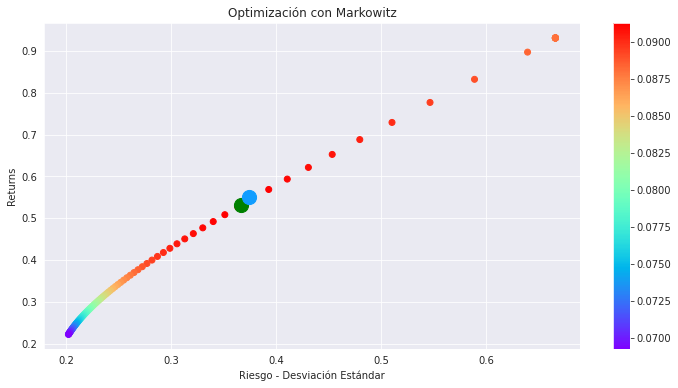

In [ ]:
####################################################################
# Calculando los pesos del modelo de Black Litterman
# usando valores historicos
####################################################################

PI_bl, sigma_bl = black_litterman(mu, sigma, w_MV.T, P, Q, tau, delta, riskfree = 0, historical = True)

w_BL_2 = Sharpe_Portafolio(np.matrix(PI_bl), sigma_bl, riskfree = 0)

#almacenando la data
SR_BL_2=[]
SR_BL_2.append([np.asscalar(PI_bl*w_BL_2*252)])
SR_BL_2.append([np.asscalar(np.sqrt(w_BL_2.T*sigma_bl*w_BL_2*252))])

#graficando la frontera con el ratio de sharpe
grafico_frontera(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar', SR_MV, SR_BL_2)
grafico_frontera_2(frontera_1, 'Optimización con Markowitz', 'Desviación Estándar', SR_MV, SR_BL_2)

Finalmente, vamos a comparar los 3 portafolios que hemos calculado para observar como es que cambian los pesos al aplicar el modelo de Black Litterman, veran que salen portafolios con pesos muy diferentes a los de Markowitz.

In [ ]:
####################################################################
# Comparando los resultados de los 3 portafolios
####################################################################

comparativo = {}
comparativo['Sharpe'] = [SR_MV[0][0]/SR_MV[1][0], SR_BL_1[0][0]/SR_BL_1[1][0], SR_BL_2[0][0]/SR_BL_2[1][0]]
comparativo['Media'] = [SR_MV[0][0], SR_BL_1[0][0], SR_BL_2[0][0]]
comparativo['Desv'] = [SR_MV[1][0], SR_BL_1[1][0], SR_BL_2[1][0]]

index = ['Markowitz', 'BL 1', 'BL 2']
a = 0
for i in tickers:
    comparativo[i] = [np.asscalar(w_MV[a]), np.asscalar(w_BL_1[a]), np.asscalar(w_BL_2[a])]
    a += 1

comparativo = pd.DataFrame(comparativo, index = index)
display(comparativo)

<ipython-input-218-832a0fe797dc>:13: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



,Sharpe,Media,Desv,WMT,GOOG,^GSPC,PEP,TSLA,MSFT,AMZN,GCARSOA1.MX,GE
Markowitz,1.449152,0.530988,0.366413,0.010000,0.033612,0.010000,0.01,0.01,0.197520,0.453688,0.265180,0.010000
BL 1,0.998834,0.351282,0.351692,0.010001,0.010001,0.010001,0.01,0.01,0.295213,0.425894,0.218889,0.010001
BL 2,1.476069,0.552060,0.374007,0.010000,0.030282,0.010000,0.01,0.01,0.173100,0.466402,0.280216,0.010000


Podríamos decir que el modelo de litterman distribuye mejor los pesos de cada una de las empresas. Haciendo este método más eficiente ante la distribución y reducción de perdidas, sin embargo, esto cambiara si se toma el parametro de historia o no. Tomando este parametro como verdadero podríamos decir que es muy similar a Markowitz.